In [9]:
import numpy as np
import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from scipy.fft import rfft, rfftfreq #outputs half
from scipy.signal import find_peaks

In [10]:
'''Column names of limbs that we care about atm:
- STRN
- LASI
- LSHO 
- LELB 
- LFIN
- LWRA
- LWRB'''

'''-------------CHOICES--------------'''
angLSHO = ["LASI","LSHO","LELB"]
angLELB = ["LSHO","LELB","LWRA"]
angLWRA = ["LELB","LWRA","LFIN"]
angRSHO = ["RASI","RSHO","RELB"]
angRELB = ["RSHO","RELB","RWRA"]
angRWRA = ["RELB","RWRA","RFIN"]

coarseness = 20 #min: 5 

#Frequency plotting things
angLST = [angLSHO,angLELB,angLWRA,angRSHO,angRELB,angRWRA] # list of angles to loop through
limbLST = ['LSHO','LELB','LWRA','RSHO','RELB','RWRA'] # list of angles to loop through

In [11]:
def np_piece_data_from_csv(num, piece, deriv=False):
    if deriv:
        filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}_d.csv' #performance number 1-6
    else:
        filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}.csv' #performance number 1-6
    repo = pd.read_csv(filename,header=0)
    columns=['Frame', 'Time (Seconds)']
    repo = repo.drop(columns, axis=1)
    vals = repo.to_numpy(dtype=float)
    mask = np.isnan(vals)
    vals[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), vals[~mask])

    return repo, vals

In [12]:
def getDegrees2D(repo, vals, POINTSx): # duplicate in 'degrees2D.ipynb'
    '''Gets angle between three points ps=[p1,p2,p3] over all frames'''
    p1x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[0]+"x") # get the x,y,z data for each of the three points over all frames
    p2x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[1]+"x")
    p3x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[2]+"x")

    unit_vector = lambda x: normalize(x, axis = 1, norm = 'l2') # helper function to normalise vectors, anonymous function woah

    v1 = vals[:,p1x:p1x+3] - vals[:,p2x:p2x+3] # 3 points -> 2 vectors
    v2 = vals[:,p3x:p3x+3] - vals[:,p2x:p2x+3]
    v1_u = unit_vector(v1) # vectors -> unit vectors
    v2_u = unit_vector(v2)
    ang = np.rad2deg(np.arccos(np.sum(v1_u*v2_u, axis=1))) # calculate angle between vectors
    return(ang) 

In [13]:
def standardize_len(lists: list[np.array]):
    '''standardize the length of the arrays by interpolation 
    (sort of stretching them performances to all be the same length for ease of comparison)'''
    x = np.linspace(0, len(lists[0]) - 1, len(lists[0]))
    standardized_len_lists = []
    for lst in lists:
        #Stretch/compress y to be the length of first list
        xp = np.linspace(x[0], x[-1], len(lst))
        new_lst = np.interp(x, xp, lst) 
        standardized_len_lists.append(new_lst) 
    return(standardized_len_lists)
    
def removeOutliers(y):
    # Calculate the IQR fences
    #print(f'{np.min(y)=} and {np.max(y)=}')
    x = np.linspace(np.min(y), np.max(y), num=len(y)) #set of x values that cover the range of the data and are sufficiently dense to capture any rapid changes in the y values. 
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Smooth the outliers with linear interpolation
    outliers = (y < lower_fence) | (y > upper_fence)
    x_outliers = x[outliers]
    f = interp1d(x[~outliers], y[~outliers], kind='linear', bounds_error=False, fill_value='extrapolate')
    y_smoothed = f(x_outliers)

    # Replace the outliers with the smoothed values
    y[outliers] = y_smoothed
    return(y)

def smooth(a, ker = 80):
    kernel_size = ker
    kernel = np.ones(kernel_size) / kernel_size
    a = np.convolve(a, kernel, mode='same') 
    a_cleaner = removeOutliers(a)
    return(a_cleaner)



def plot_fft(piece: int, perfs: list[int], limb: list[str], smoothker: int, xlim: list[int] = [0,3], ylim: list[int] = [0,27500], DERIV: bool = False, save: bool = False) -> None:
    fig1 = plt.figure(figsize=(10, 6))
    ax1 = fig1.add_subplot(111)

    fig2 = plt.figure(figsize=(10, 6))
    ax2 = fig2.add_subplot(111)

    angLST = []
    for perf in perfs:
        repo,vals = np_piece_data_from_csv(perf,piece,deriv=DERIV)
        ang = smooth(getDegrees2D(repo, vals, POINTSx = limb), ker=smoothker)
        angLST.append(ang)

    stand_len_angLST = standardize_len(angLST)

    for count,elem in enumerate(stand_len_angLST):
        labl = f'{limb[1]}_perf{elem}'
        ln=np.size(elem,0)
        X = np.linspace(0, ln//240, ln) 
        N = np.size(X)
        yf = rfft(elem)
        xf = rfftfreq(N, 1/(sr := 240))
        ax1.plot(X, elem, label=perfs[count])
        ax2.plot(xf, np.abs(yf), label=perfs[count])

    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Amplitude")
    ax1.legend()
    ax1.set_title(f'{limb[1]} angle, piece {piece} over time, smoothed with a kernel of {smoothkernel}')

    ax2.set_xlabel("Frequency [Hz]")
    ax2.set_ylabel("Amplitude")
    ax2.legend()
    ax2.set_title(f'{limb[1]} angle, piece {piece} frequency plot, from data smoothed with a kernel of {smoothkernel}')
    ax2.set_xlim(xlim[0],xlim[1])
    ax2.set_ylim(ylim[0],ylim[1])

    if save:
        plt.savefig(f'visuals/frequencies_piece{piece}.png')

In [14]:
def plot_fft_w_peaks(piece: int, perfs: list[int], limb: list[str], smoothker: int, PROMINENCE: float = 0.5, WIDTH: float = 0.2, xlim: list[int] = [0,3], ylim: list[int] = [0,27500], nonFFTplot = False, DERIV: bool = False, PLOT: bool = True, save: bool = False):
    if PLOT:
        if nonFFTplot:
            fig1 = plt.figure(figsize=(10, 6))
            ax1 = fig1.add_subplot(111)

        fig2 = plt.figure(figsize=(10, 6))
        ax2 = fig2.add_subplot(111)

    angLST = []
    for perf in perfs:
        repo,vals = np_piece_data_from_csv(perf,piece,deriv=DERIV)
        ang = smooth(getDegrees2D(repo, vals, POINTSx = limb), ker=smoothker)
        angLST.append(ang)

    stand_len_angLST = standardize_len(angLST)
    peakLST = []
    for count,elem in enumerate(stand_len_angLST):
        labl = f'{limb[1]}_perf{elem}'
        ln=np.size(elem,0)
        X = np.linspace(0, ln//240, ln) 
        N = np.size(X)
        yf = rfft(elem)
        xf = rfftfreq(N, 1/(sr := 240))

        # Find the peaks in the signal
        peaks, _ = find_peaks(np.abs(yf), prominence=PROMINENCE, width=WIDTH)
        if PLOT:
            if nonFFTplot: ax1.plot(X, elem, label=perfs[count])
            ax2.plot(xf, np.abs(yf), label=perfs[count])
            ax2.plot(xf[peaks], np.abs(yf)[peaks], "x")

        # add the index of the peaks, the x and the y values at which they occur to a list
        peakLST.append([peaks, xf[peaks], np.abs(yf)[peaks]])

    if PLOT:
        if nonFFTplot:
            ax1.set_xlabel("Time [s]")
            ax1.set_ylabel("Amplitude")
            ax1.legend()
            ax1.set_title(f'{limb[1]} angle, piece {piece} over time, smoothed with a kernel of {smoothkernel}, {DERIV=}')
        ax2.set_xlabel("Frequency [Hz]")
        ax2.set_ylabel("Amplitude")
        ax2.legend()
        ax2.set_title(f'{limb[1]} angle, piece {piece} frequency plot, from data smoothed with a kernel of {smoothkernel},  {DERIV=}')
        ax2.set_xlim(xlim[0],xlim[1])
        ax2.set_ylim(ylim[0],ylim[1])

    if save:
        plt.savefig(f'visuals/frequencies_piece{piece}.png')

    return(peakLST)

2. Do exercises have a greater impact on the movement frequencies of wrist/elbow than of shoulder?

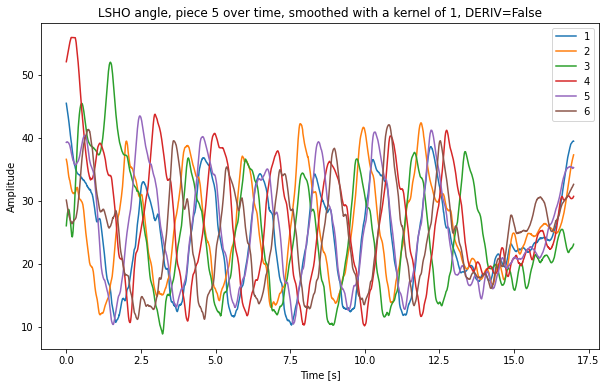

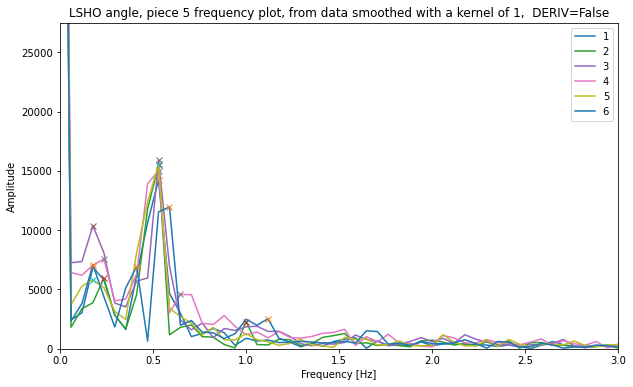

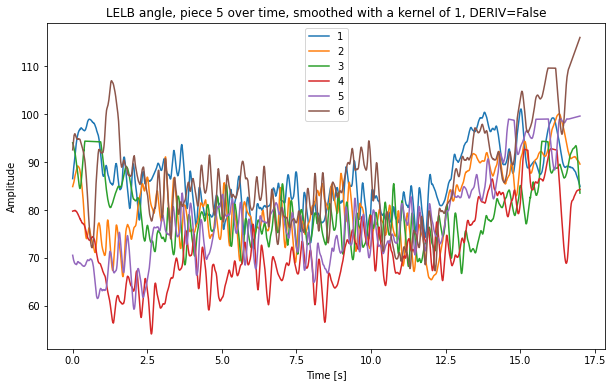

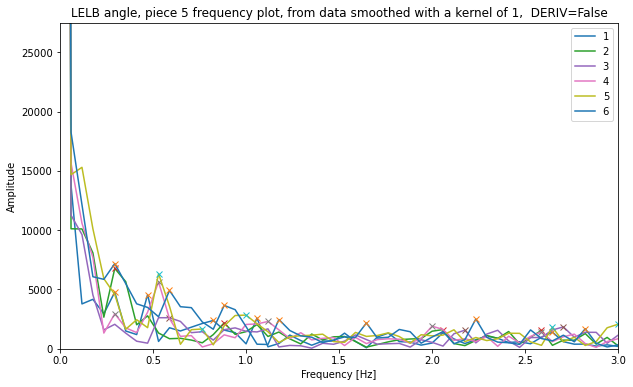

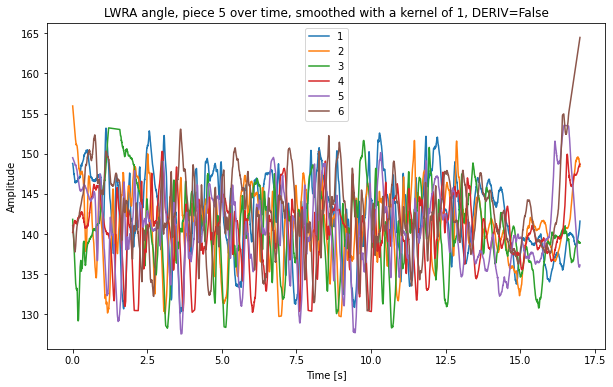

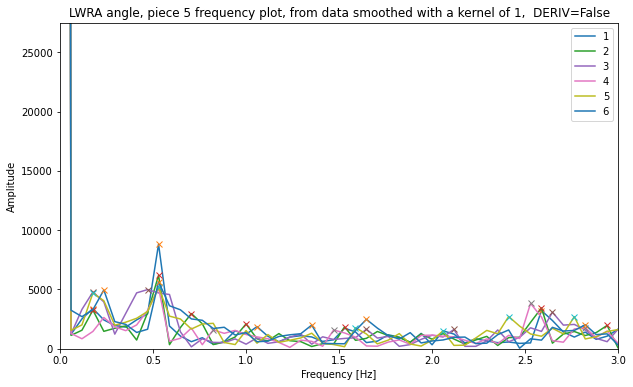

In [15]:
piece = 5 # can choose either multiple pieces or multiple performances for one angle
perfs = [1,2,3,4,5,6]
limb = angLSHO

smoothkernel = 1
p = 1200
w = 0.5
plot1 = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, nonFFTplot=True, PROMINENCE = p, WIDTH = w)
limb = angLELB
plot2 = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, nonFFTplot=True, PROMINENCE = p, WIDTH = w)
limb = angLWRA
plot3 = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, nonFFTplot=True, PROMINENCE = p, WIDTH = w)



3. Do you have fewer principle periodic components to movement as you exercise? 

In [22]:
smoothkernel = 1
p = 600
w = 0.5

num_pcs = []
for limb in angLST:
    pieces_in_limb = []
    for piece in [1,2,3,5,6]:
        perfs_in_piece = []
        for perf in [1,2,3,4,5,6]:
            peaks = plot_fft_w_peaks(piece, [perf], limb, smoothkernel, nonFFTplot=False, PROMINENCE = p, WIDTH = w, PLOT = False)
            perfs_in_piece.append(len(peaks[0][0]))
        pieces_in_limb.append(perfs_in_piece)
    print(f'{limb=}, {pieces_in_limb}')
    num_pcs.append(pieces_in_limb)


limb=['LASI', 'LSHO', 'LELB'], [[21, 16, 18, 20, 16, 13], [13, 16, 16, 15, 18, 19], [12, 9, 10, 9, 8, 11], [5, 5, 5, 7, 5, 5], [21, 24, 28, 33, 24, 26]]
limb=['LSHO', 'LELB', 'LWRA'], [[23, 24, 22, 21, 23, 17], [24, 30, 26, 23, 30, 33], [21, 19, 19, 14, 13, 12], [13, 12, 8, 8, 13, 16], [27, 24, 27, 32, 25, 23]]
limb=['LELB', 'LWRA', 'LFIN'], [[19, 13, 10, 15, 14, 14], [20, 20, 19, 17, 19, 21], [19, 20, 17, 19, 16, 18], [14, 15, 10, 10, 14, 13], [25, 21, 22, 30, 23, 37]]
limb=['RASI', 'RSHO', 'RELB'], [[36, 29, 28, 20, 25, 21], [16, 16, 18, 16, 17, 13], [11, 8, 10, 11, 11, 14], [6, 10, 9, 9, 7, 14], [26, 29, 27, 33, 25, 37]]
limb=['RSHO', 'RELB', 'RWRA'], [[27, 33, 26, 28, 31, 28], [21, 20, 24, 20, 23, 26], [10, 9, 11, 10, 11, 9], [16, 13, 13, 13, 16, 19], [35, 29, 28, 39, 38, 42]]
limb=['RELB', 'RWRA', 'RFIN'], [[20, 23, 23, 22, 36, 26], [16, 25, 22, 15, 18, 12], [13, 14, 13, 17, 16, 11], [15, 12, 13, 12, 13, 14], [31, 22, 33, 29, 27, 29]]


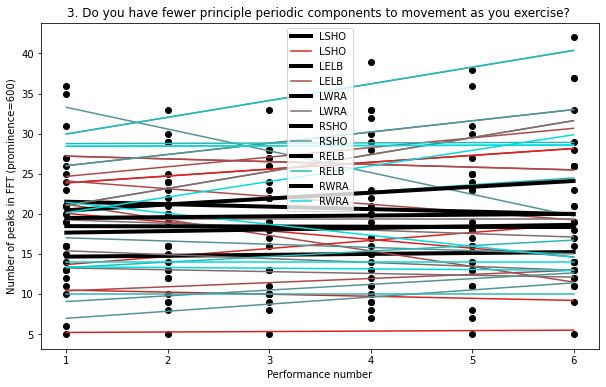

In [23]:
x = [1,2,3,4,5,6]
plt.figure(figsize=(10, 6))
for count, ang in enumerate(num_pcs):
    ms_ang = []
    bs_ang = []
    for y in ang:
        x, y = np.array(x), np.array(y)
        # Calculate the line of best fit
        m, b = np.polyfit(x,y, 1)
        ms_ang.append(m)
        bs_ang.append(b)
        # Plot the scatter plot
        plt.scatter(x, y, color='black')
        # Add the line of best fit to the plot
        plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7))
    plt.plot(x,sum(ms_ang)/len(ms_ang)*x + sum(bs_ang)/len(bs_ang), color="black", linewidth=4.0,label=angLST[count][1])
    plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7), label=angLST[count][1])

# Add labels and title
plt.xlabel('Performance number')
plt.ylabel(f'Number of peaks in FFT (prominence={p})')
plt.title('3. Do you have fewer principle periodic components to movement as you exercise? ')
plt.legend()
# Show the plot
plt.show()

# no trend by limb

The average slope is 0.1352380952380944


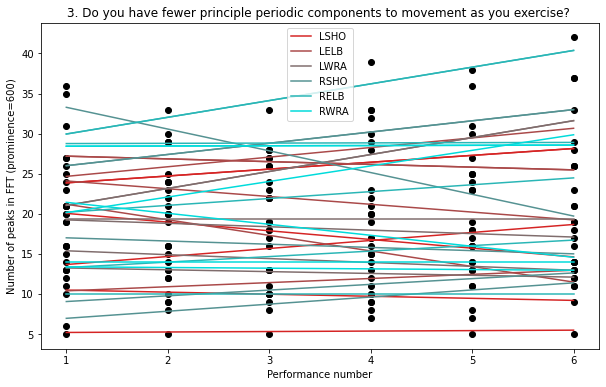

In [38]:
plt.figure(figsize=(10, 6))
x = [1,2,3,4,5,6]
ms_ang = []
for count, ang in enumerate(num_pcs):
    for y in ang:
        x, y = np.array(x), np.array(y)
        # Calculate the line of best fit
        m, b = np.polyfit(x,y, 1)
        ms_ang.append(m)
        # Plot the scatter plot
        plt.scatter(x, y, color='black')
        # Add the line of best fit to the plot
        plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7))
    plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7), label=angLST[count][1])

print(f"The average slope is {sum(ms_ang)/len(ms_ang)}")


# Add labels and title
plt.xlabel('Performance number')
plt.ylabel(f'Number of peaks in FFT (prominence={p})')
plt.title('3. Do you have fewer principle periodic components to movement as you exercise? ')
plt.legend()
# Show the plot
plt.show()

# no trend by limb

The average slope for perf 1 to 2 is -0.5333333333333339


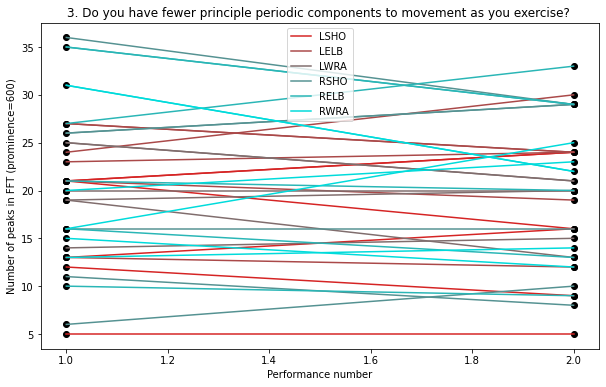

The average slope for perf 2 to 3 is -0.16666666666666283


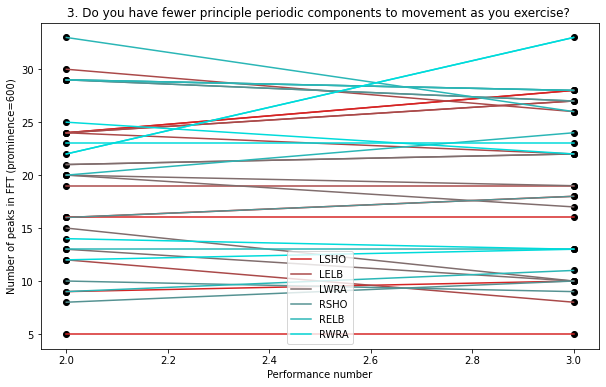

The average slope for perf 3 to 4 is 0.40000000000000013


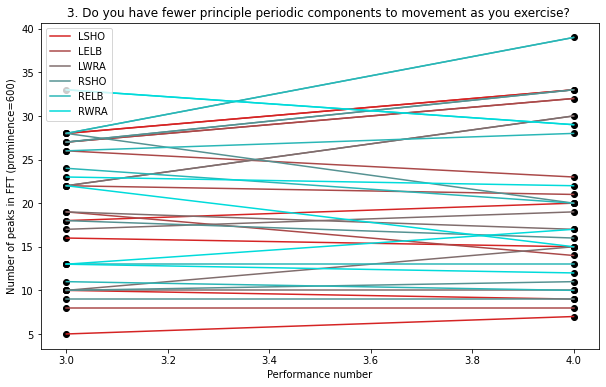

The average slope for perf 4 to 5 is 0.26666666666666433


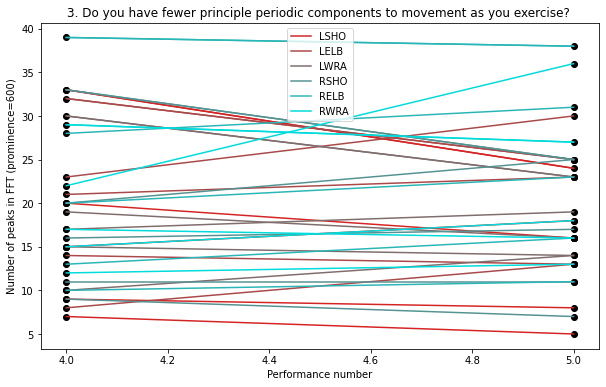

The average slope for perf 5 to 6 is 0.6000000000000013


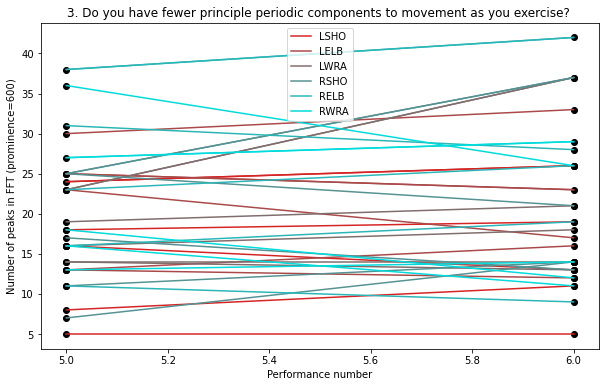

In [39]:
# Separating by performances
for x in [[1,2],[2,3],[3,4],[4,5],[5,6]]:
    plt.figure(figsize=(10, 6))
    ms_ang = []
    for count, ang in enumerate(num_pcs):
        for y in ang:
            x, y = np.array(x), np.array(y[x[0]-1:x[0]+1])
            # Calculate the line of best fit
            m, b = np.polyfit(x,y, 1)
            ms_ang.append(m)
            # Plot the scatter plot
            plt.scatter(x, y, color='black')
            # Add the line of best fit to the plot
            plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7))
        plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7), label=angLST[count][1])

    print(f"The average slope for perf {x[0]} to {x[1]} is {sum(ms_ang)/len(ms_ang)}")


    # Add labels and title
    plt.xlabel('Performance number')
    plt.ylabel(f'Number of peaks in FFT (prominence={p})')
    plt.title('3. Do you have fewer principle periodic components to movement as you exercise? ')
    plt.legend()
    # Show the plot
    plt.show()

# no trend by limb

5
For piece 1, the average slope is -0.5476190476190482


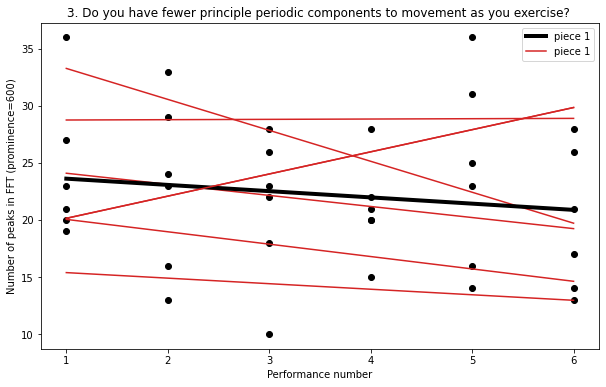

For piece 2, the average slope is 0.21428571428571355


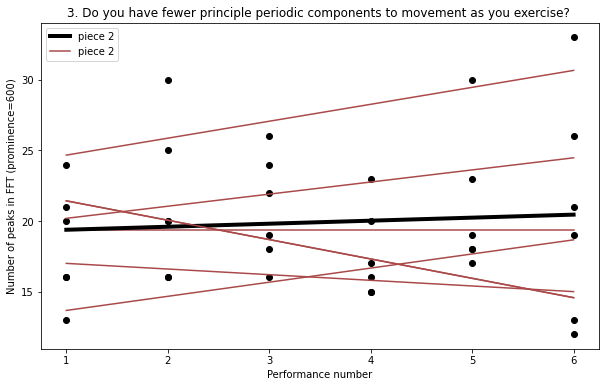

For piece 3, the average slope is -0.3190476190476197


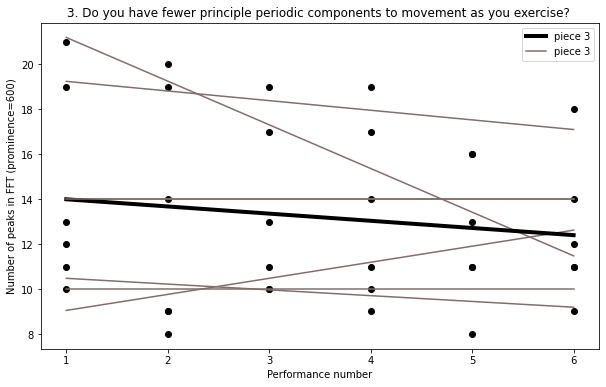

For piece 5, the average slope is 0.304761904761904


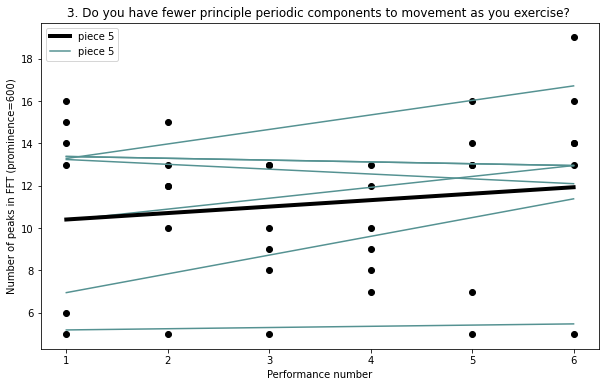

For piece 6, the average slope is 1.0238095238095224


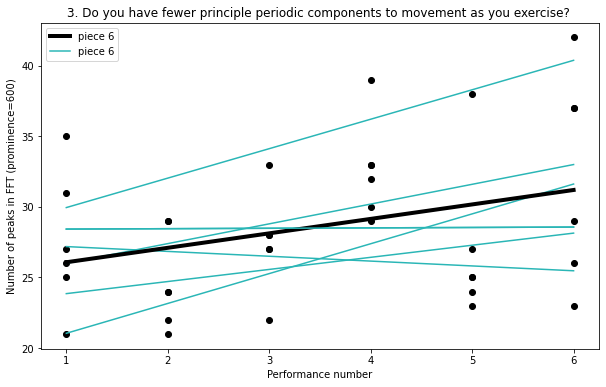

In [29]:
x = [1,2,3,4,5,6]
pieces = [1,2,3,5,6]

# order list by piece, not limb
l = len(num_pcs[0])
num_pcsT = [[] for _ in range(l)] # Create a list of n lists, each with a single element
for i in range(l):
    num_pcsT[i] = [sublist[i] for sublist in num_pcs]
print(len(num_pcsT))

for count, piece in enumerate(num_pcsT):
    ms_ang = []
    bs_ang = []
    plt.figure(figsize=(10, 6))
    for y in piece:
        x, y = np.array(x), np.array(y)
        # Calculate the line of best fit
        m, b = np.polyfit(x,y, 1)
        ms_ang.append(m)
        bs_ang.append(b)
        # Plot the scatter plot
        plt.scatter(x, y, color='black')
        # Add the line of best fit to the plot
        plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7))
    print(f"For piece {pieces[count]}, the average slope is {sum(ms_ang)/len(ms_ang)}")
    plt.plot(x,sum(ms_ang)/len(ms_ang)*x + sum(bs_ang)/len(bs_ang), color="black", linewidth=4.0,label=f'piece {pieces[count]}')
    plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7), label=f'piece {pieces[count]}')

    # Add labels and title
    plt.xlabel('Performance number')
    plt.ylabel(f'Number of peaks in FFT (prominence={p})')
    plt.title('3. Do you have fewer principle periodic components to movement as you exercise? ')
    plt.legend()
    # Show the plot
    plt.show()

    # Looks like theses are actually really unsuitable to be fit by lines


Try other prominence:

In [47]:
smoothkernel = 1
p = 200
w = 0.5

num_pcs2 = []
for limb in angLST:
    pieces_in_limb = []
    for piece in [1,2,3,5,6]:
        perfs_in_piece = []
        for perf in [1,2,3,4,5,6]:
            peaks = plot_fft_w_peaks(piece, [perf], limb, smoothkernel, nonFFTplot=False, PROMINENCE = p, WIDTH = w, PLOT = False)
            perfs_in_piece.append(len(peaks[0][0]))
        pieces_in_limb.append(perfs_in_piece)
    print(f'{limb=}, {pieces_in_limb}')
    num_pcs2.append(pieces_in_limb)

limb=['LASI', 'LSHO', 'LELB'], [[41, 33, 39, 31, 27, 26], [29, 33, 33, 26, 31, 36], [20, 17, 17, 16, 13, 19], [11, 13, 11, 16, 13, 16], [39, 46, 40, 49, 39, 41]]
limb=['LSHO', 'LELB', 'LWRA'], [[44, 51, 49, 51, 51, 39], [44, 47, 44, 40, 48, 49], [31, 28, 31, 26, 23, 27], [22, 24, 21, 20, 34, 25], [52, 54, 49, 71, 51, 54]]
limb=['LELB', 'LWRA', 'LFIN'], [[36, 27, 29, 36, 35, 31], [45, 49, 42, 39, 47, 41], [37, 38, 29, 32, 32, 30], [31, 33, 29, 35, 32, 36], [51, 47, 46, 63, 55, 65]]
limb=['RASI', 'RSHO', 'RELB'], [[49, 46, 47, 36, 37, 37], [27, 27, 24, 25, 32, 26], [20, 16, 21, 17, 17, 22], [15, 24, 18, 16, 23, 22], [44, 42, 43, 46, 45, 59]]
limb=['RSHO', 'RELB', 'RWRA'], [[58, 57, 57, 54, 54, 63], [42, 37, 43, 37, 41, 42], [20, 25, 22, 25, 21, 24], [25, 25, 31, 24, 31, 33], [62, 57, 63, 68, 68, 80]]
limb=['RELB', 'RWRA', 'RFIN'], [[51, 55, 54, 56, 71, 56], [36, 53, 42, 36, 38, 35], [28, 26, 26, 36, 37, 30], [27, 39, 30, 37, 33, 40], [63, 65, 83, 74, 68, 69]]


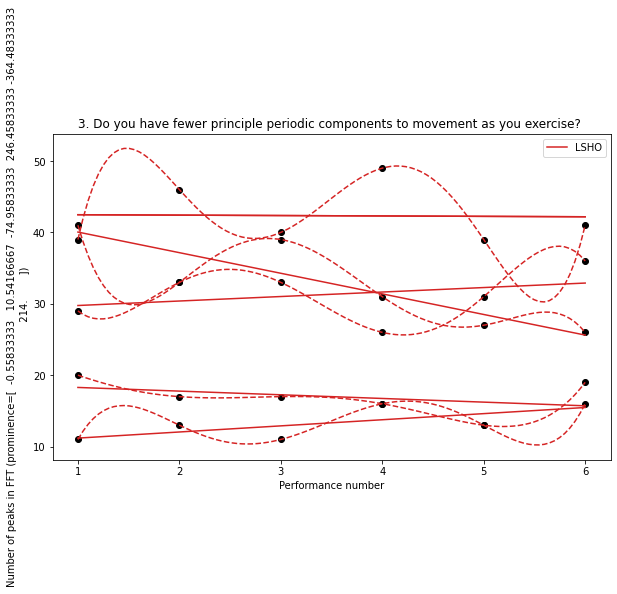

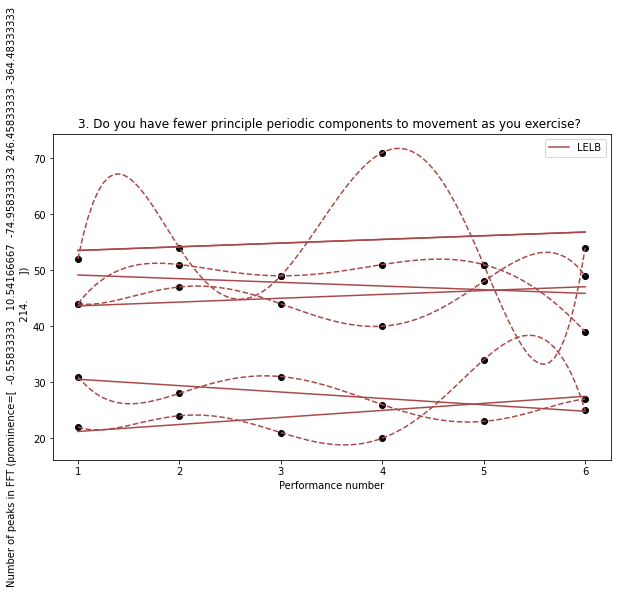

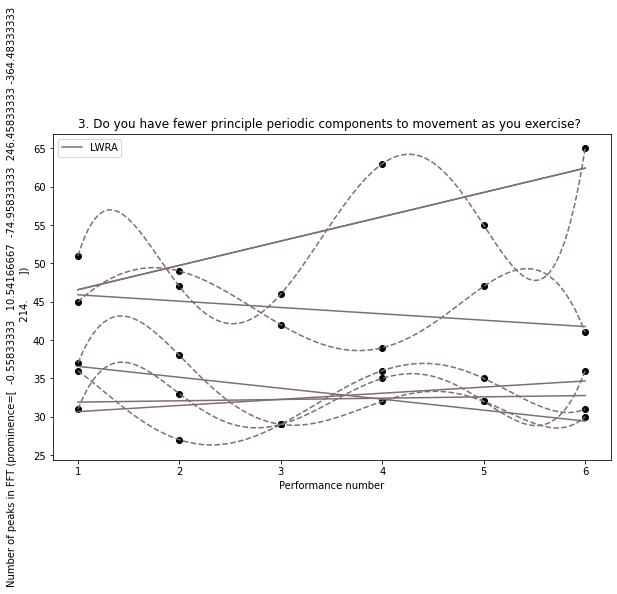

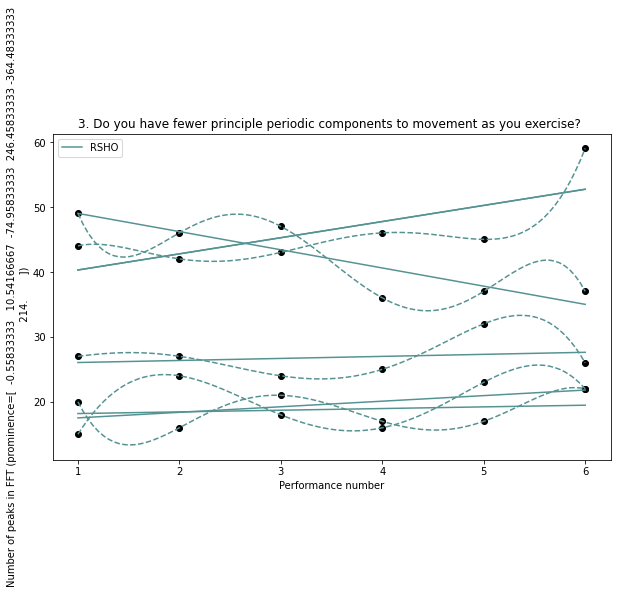

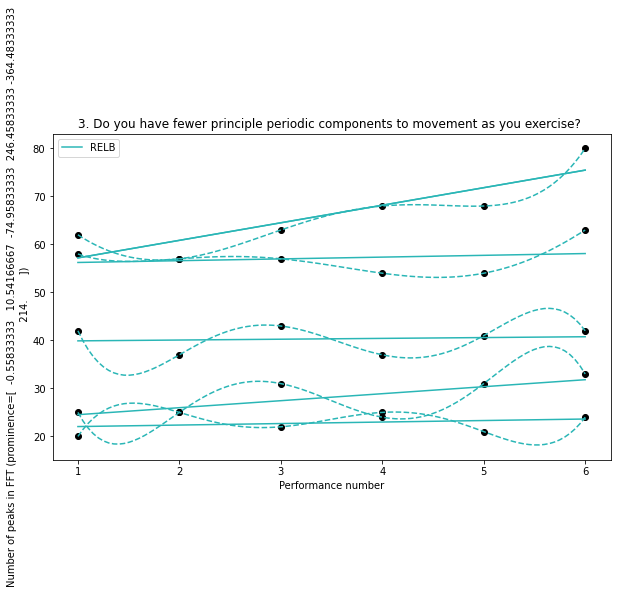

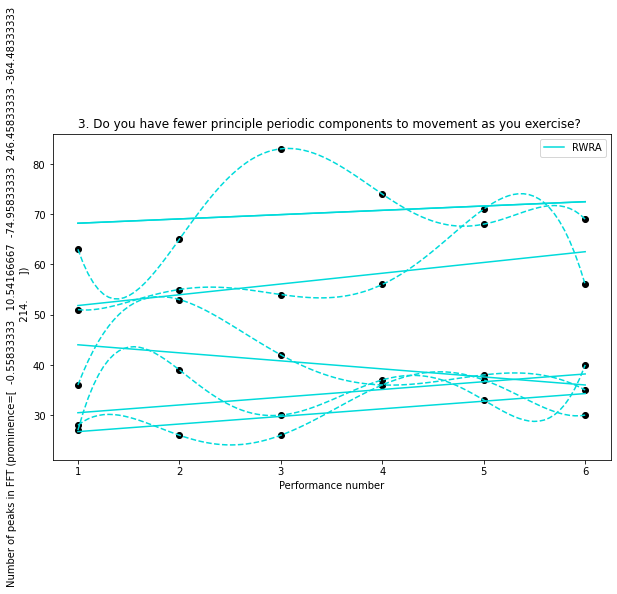

In [55]:
# The same thing as above, but without the last performance
# Also including a higher polynomial fit
# by limb


x = [1,2,3,4,5,6]
for count, ang in enumerate(num_pcs2):
    plt.figure(figsize=(10, 6))
    ms_ang = []
    bs_ang = []
    for y in ang:
        x, y = np.array(x), np.array(y)
        # Calculate the line of best fit
        m, b = np.polyfit(x,y, 1)
        ms_ang.append(m)
        bs_ang.append(b)
        # Plot the scatter plot
        plt.scatter(x, y, color='black')

        pol = np.polyfit(x,y, 5)
        # Evaluate the polynomial at 100 evenly spaced points
        x_fit = np.linspace(x.min(), x.max(), 100)
        y_fit = np.polyval(pol, x_fit)
        # Plot the data and the polynomial fit
        #plt.plot(x, y, 'o', color=(1- (count+1)/6,(count+1)/7, (count+1)/7))
        plt.plot(x_fit, y_fit, linestyle='--', color=(1- (count+1)/6,(count+1)/7, (count+1)/7))


        # Add the line of best fit to the plot
        plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7))
    #plt.plot(x,sum(ms_ang)/len(ms_ang)*x + sum(bs_ang)/len(bs_ang), color="black", linewidth=4.0,label=angLST[count][1])
    plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7), label=angLST[count][1])

    # Add labels and title
    plt.xlabel('Performance number')
    plt.ylabel(f'Number of peaks in FFT (prominence={p})')
    plt.title('3. Do you have fewer principle periodic components to movement as you exercise? ')
    plt.legend()
    # Show the plot
    plt.show()


5
For piece 1, the average slope is -0.2166666666666699


/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anacon

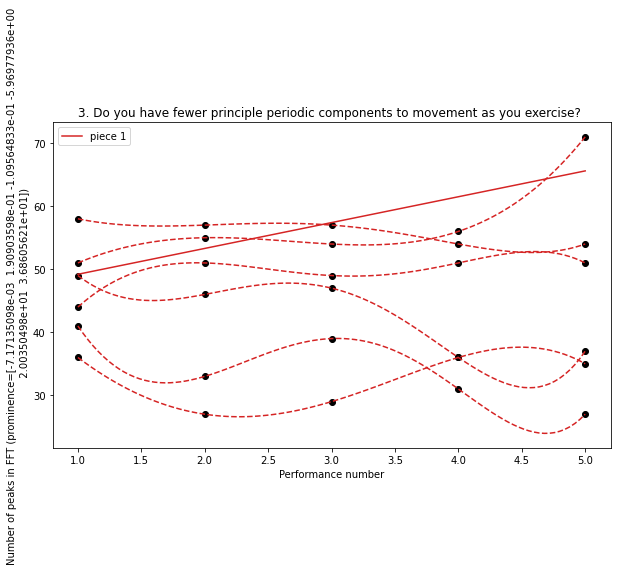

/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


For piece 2, the average slope is -0.2500000000000018


/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


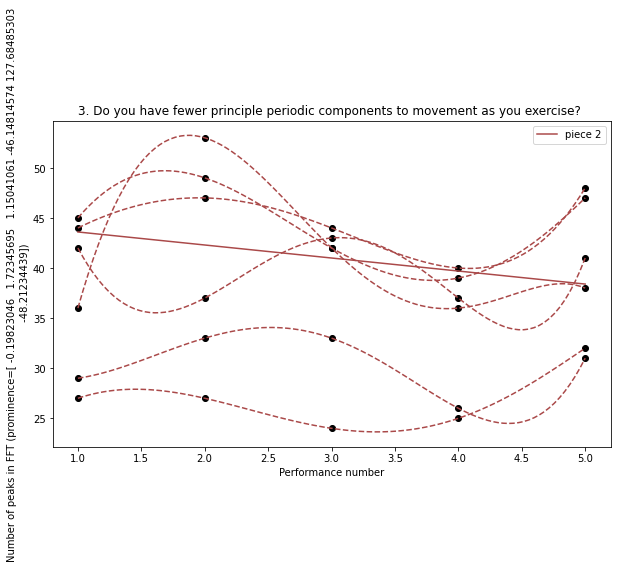

/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anacon

For piece 3, the average slope is -0.40000000000000013


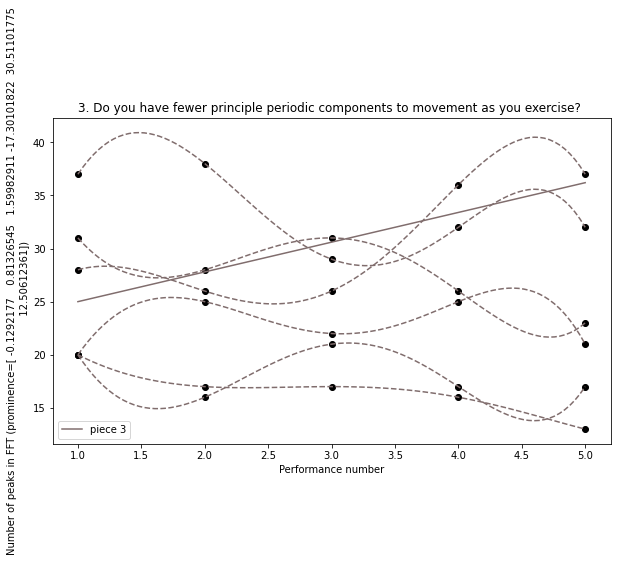

For piece 5, the average slope is 0.9999999999999994


/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anacon

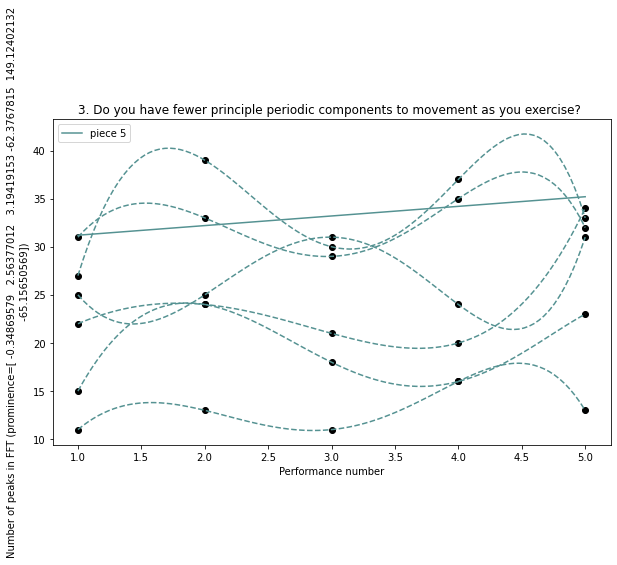

/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


For piece 6, the average slope is 1.4999999999999976


/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/HAQbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


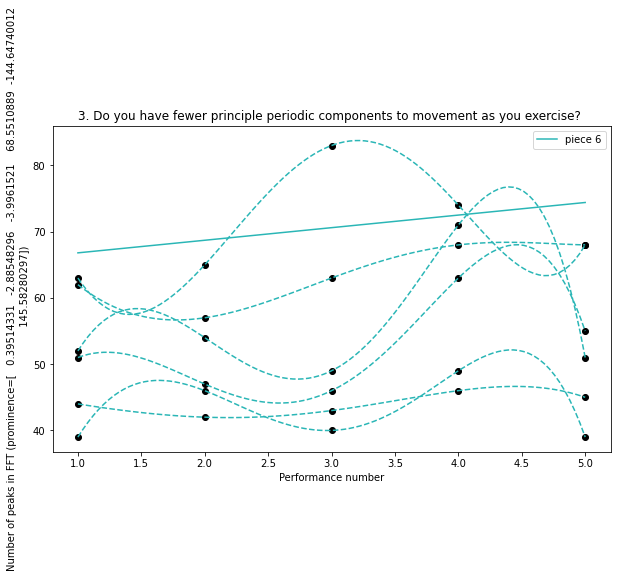

In [50]:
# The same thing as above, but without the last performance
# Also including a higher polynomial fit
# by piece

x = [1,2,3,4,5]
pieces = [1,2,3,5,6]

# order list by piece, not limb
l = len(num_pcs2[0])
num_pcs2T = [[] for _ in range(l)] # Create a list of n lists, each with a single element
for i in range(l):
    num_pcs2T[i] = [sublist[i] for sublist in num_pcs2]
print(len(num_pcs2T))

for count, piece in enumerate(num_pcs2T):
    ms_ang = []
    bs_ang = []
    plt.figure(figsize=(10, 6))
    for y in piece:
        x, y = np.array(x), np.array(y[:5])
        plt.scatter(x, y, color='black') # Plot the scatter plot

        # Calculate the line of best fit
        m, b = np.polyfit(x,y, 1)
        ms_ang.append(m)
        bs_ang.append(b)
        # Add the line of best fit to the plot
        #plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7))

        p = np.polyfit(x,y, 5)
        # Evaluate the polynomial at 100 evenly spaced points
        x_fit = np.linspace(x.min(), x.max(), 100)
        y_fit = np.polyval(p, x_fit)
        # Plot the data and the polynomial fit
        #plt.plot(x, y, 'o', color=(1- (count+1)/6,(count+1)/7, (count+1)/7))
        plt.plot(x_fit, y_fit, linestyle='--', color=(1- (count+1)/6,(count+1)/7, (count+1)/7))

    print(f"For piece {pieces[count]}, the average slope is {sum(ms_ang)/len(ms_ang)}")
    #plt.plot(x,sum(ms_ang)/len(ms_ang)*x + sum(bs_ang)/len(bs_ang), color="black", linewidth=4.0,label=f'piece {pieces[count]}')
    plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7), label=f'piece {pieces[count]}')

    # Add labels and title
    plt.xlabel('Performance number')
    plt.ylabel(f'Number of peaks in FFT (prominence={p})')
    plt.title('3. Do you have fewer principle periodic components to movement as you exercise? ')
    plt.legend()
    # Show the plot
    plt.show()

    # Looks like theses are actually really unsuitable to be fit by lines


what's the relation between number of peaks in various limbs?

In [ ]:
limbs = [1,2,3,4,5,6]
pieces = [1,2,3,5,6]

plt.figure(figsize=(10, 6))
for count, ang in enumerate(num_pcs):
    ms_ang = []
    bs_ang = []
    for y in ang:
        x, y = np.array(x), np.array(y)
        # Calculate the line of best fit
        m, b = np.polyfit(x,y, 1)
        ms_ang.append(m)
        bs_ang.append(b)
        # Plot the scatter plot
        plt.scatter(x, y, color='black')
        # Add the line of best fit to the plot
        plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7))
    plt.plot(x,sum(ms_ang)/len(ms_ang)*x + sum(bs_ang)/len(bs_ang), color="black", linewidth=4.0,label=angLST[count][1])
    plt.plot(x, m*x + b, color=(1- (count+1)/6,(count+1)/7, (count+1)/7), label=angLST[count][1])

# Add labels and title
plt.xlabel('Performance number')
plt.ylabel(f'Number of peaks in FFT (prominence={p})')
plt.title('3. Do you have fewer principle periodic components to movement as you exercise? ')
plt.legend()
# Show the plot
plt.show()
